# Enhanced Self-RAG

## Setup

First let's install our required packages and set our API keys

In [3]:
from dotenv import load_dotenv
import pprint
from uuid import uuid4

In [4]:
# Make sure you have OPENAI_API_BASE and OPENAI_API_KEY defined as environment variables e.g. in a .env file
# Feel free to substitute with other services e.g. OpenRouter
load_dotenv()

True

Define the embedding model and LLM we want to use

In [5]:
embedding_model = "all-MiniLM-L6-v2"
llm_model = "anthropic/claude-3.5-sonnet" # You can choose another model, but please make sure "tools" is a supported parameter

In [6]:
from langchain_openai import ChatOpenAI

# I am using temperature 0 to get more deterministic results
llm = ChatOpenAI(model=llm_model, temperature=0)
llm.invoke("hello")

AIMessage(content='Hi! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 8, 'total_tokens': 21, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'anthropic/claude-3.5-sonnet', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-35c7ede5-f8ef-4d72-aa39-13904d395c92-0', usage_metadata={'input_tokens': 8, 'output_tokens': 13, 'total_tokens': 21, 'input_token_details': {}, 'output_token_details': {}})

## Retriever
 
Let's index the 2 webpages I have mentioned in the article

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

urls = [
    "https://www.eu-startups.com/2024/04/comparative-analysis-eu-vs-us-flight-compensation-policies-sponsored/",
    "https://www.geodatos.net/en/distances/cities/germany/bavaria/munich"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=HuggingFaceEmbeddings(model_name=embedding_model)
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
# Test the retriever
docs = retriever.invoke("how much can I receive if I am denied boarding, for flights from Delhi to Munich?")
for d in docs:
    print("-------------------------------------------------\n"+d.page_content)

-------------------------------------------------
Overview of US Flight Compensation Policies
To get compensation for delayed flights, you should contact your airline via their customer service or go to the customer service desk. At the same time, you should bear in mind that you will only receive compensation if the delay is not weather-related and is within the carrier`s control.
According to the US Department of Transportation, US airlines are not required to compensate you if a flight is cancelled or delayed. You can be compensated if you are bumped or moved from an overbooked flight.
If your provider cancels your flight less than two weeks before departure and you decide to cancel your trip entirely, you can receive a refund of both pre-paid baggage fees and your plane ticket. There will be no refund if you choose to continue your journey.
In the case of a delayed flight, the airline will rebook you on a different flight. According to federal law, you will not be provided with mon

## LLMs

In [9]:
### Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(schema=GradeDocuments, method='function_calling')

# Prompt
system = """You are a grader assessing relevance of a retrieved document to the questions. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the questions, grade it as relevant. Think step by step\n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n Questions: {questions}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
questions = "what's the denied boarding compensation for medium haul flights?"
docs = retriever.invoke(questions)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"questions": questions, "document": doc_txt}))

binary_score='no'


In [10]:
### Generate
from langchain_core.prompts import PromptTemplate

# Prompt. Copied from prompty_library/chat.prompty
prompt = PromptTemplate.from_template("""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
Do not make things up. If the answer is not in the context, say that you don't know.

Question: {question} 
Context: {context} 
Answer:
""")

# Chain
rag_chain = prompt | llm

# Run
generation = rag_chain.invoke({"context": docs, "question": questions})
print(generation.content)

From the provided context, I cannot determine the specific denied boarding compensation amount for medium haul flights. While the context mentions that compensation in the EU is calculated based on distance (with an example of 250 euros for flights up to 1,500 km), it doesn't explicitly state the compensation amount for medium haul flights. The context mainly discusses general differences between EU and US compensation policies and doesn't provide complete details about compensation amounts for different flight distances.


In [11]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(schema=GradeHallucinations, method='function_calling')

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts. Think step by step."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {useful_documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"useful_documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [12]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(schema=GradeAnswer, method='function_calling')

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": questions, "generation": generation})

GradeAnswer(binary_score='no')

In [13]:
### Question Re-writer
from typing import List

class NewQueries(BaseModel):
    """New question to issue against vectorstore"""

    new_queries: List[str] = Field(
        description="New questions to issue against vectorstore"
    )

high_temp_llm = llm.model_copy()
high_temp_llm.temperature = 0.5
structured_llm_rewriter = high_temp_llm.with_structured_output(schema=NewQueries, method='function_calling')

# Prompt
system = """You a question re-writer that raise multiple follow-up questions, for retrieving missing data in answering the initial question, given the known context.
            Look at the initial question and try to reason about the underlying semantic intent / meaning
            
            Think step by step when formulating the new question, also considering the hypothesis.
            Ensure the new questions are different from what had been issued before.

            Returns empty list if no new questions can be formulated.
            """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            """
            Here is the initial question: \n\n {question} \n
            Hypothesis: \n\n {hypothesis} \n
            Questions that have been issued before: \n\n {new_queries} \n
            Known context: \n\n {useful_documents} \n

            Formulate new questions.
            """,
        ),
    ]
)

question_rewriter = re_write_prompt | structured_llm_rewriter

# Run
new_queries = ""
useful_documents = ""
hypothesis = ""
new_queries = question_rewriter.invoke({"question": questions, "new_queries": new_queries, "useful_documents": useful_documents, "hypothesis": hypothesis}).new_queries
new_queries

['What are the compensation amounts for denied boarding on medium haul flights?',
 'What is considered a medium haul flight in terms of distance or duration?',
 'What are the conditions for receiving denied boarding compensation?',
 'Are there different compensation tiers based on the delay length for medium haul flights?',
 'What documentation is needed to claim denied boarding compensation for medium haul flights?']

# Graph 

Capture the flow in as a graph.

## Graph state

In [14]:
from typing import List, Annotated
from typing_extensions import TypedDict

def append_to_list(original: list, new: list) -> list:
    original.append(new)
    return original

def combine_list(original: list, new: list) -> list:
    return original + new

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        new_documents: newly retrieved documents for the current iteration
        useful_documents: documents that are considered useful
        graded_documents: documents that have been graded
        new_queries: newly generated questions
        hypothesis: hypothesis
    """

    question: str
    generation: str
    new_documents: List[str]
    useful_documents: Annotated[List[str], combine_list]
    graded_documents: List[str]
    new_queries: Annotated[List[str], append_to_list]
    hypothesis: str

In [15]:
### Nodes

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    if not state.get("new_queries", ""):
        state["new_queries"] = [[state["question"]]]
    new_queries_to_vector_store = state["new_queries"][-1]

    # Retrieval
    new_documents = []
    for q in new_queries_to_vector_store:
        new_documents += retriever.invoke(q)

    # Keep only the documents with unique id
    unique_new_docs = []
    unique_ids = []
    for doc in new_documents:
        doc_id = doc.id
        if doc_id not in unique_ids:
            unique_ids.append(doc_id)
            unique_new_docs.append(doc)

    # Remove the metadata.@search.captions field, which causes the error "Object of type QueryCaptionResult is not serializable"
    for doc in unique_new_docs:
        search_captions = doc.metadata.get("@search.captions","")
        if search_captions:
            del doc.metadata["@search.captions"]

    return {"new_documents": unique_new_docs}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    useful_documents = state["useful_documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": '\n'.join([d.page_content for d in useful_documents]), "question": question})
    return {"generation": generation.content}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    questions = [[state["question"]]] + state["new_queries"]
    questions_to_string = '\n'.join([q for sublist in questions for q in sublist])
    
    new_documents = state["new_documents"]
    graded_documents = state.get("graded_documents", [])

    # Score each doc
    filtered_docs = []
    graded_docs_ids = [d.id for d in graded_documents]
    for d in new_documents:
        # Check if the document has already been graded
        if d.id in graded_docs_ids:
            continue
        else:
            # Grade the document
            score = retrieval_grader.invoke(
                {"questions": questions_to_string, "document": d.page_content}
            )
            grade = score.binary_score

            # Add the document to the graded list
            graded_documents.append(d)

            # Add useful documents to the list
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                continue

    # Generate hypothesis
    hypothesis = llm.invoke(f"""
        Given context, form hypothesis for the information you need to answer user's question.

        Context: {[c.page_content for c in state["useful_documents"] + state["new_documents"]]}
        User's question: {state["question"]}
        Hypothesis:
        """).content

    return {"useful_documents": filtered_docs, "graded_documents": graded_documents, "hypothesis": hypothesis}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")


    # Re-write question
    new_queries = question_rewriter.invoke({
        "question": state["question"],
        "new_queries": state["new_queries"],
        "useful_documents": '\n'.join([d.page_content for d in state["useful_documents"]]),
        "hypothesis": state["hypothesis"]
        })
    return {"new_queries": new_queries.new_queries}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["useful_documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    useful_documents = state["useful_documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"useful_documents": '\n'.join([d.page_content for d in useful_documents]), "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

The just follows the flow we outlined in the figure above.

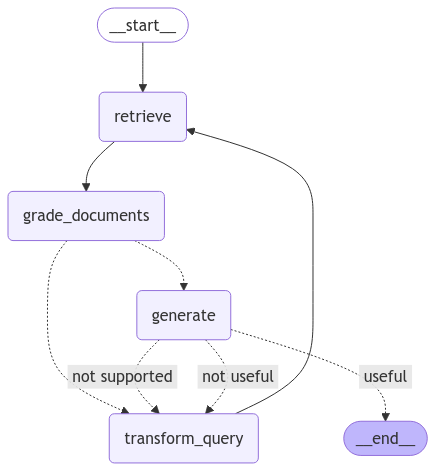

In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not supported": "transform_query",
        "not useful": "transform_query",
    },
)

# Compile
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

Note: The graph as a recursion limit of 25

## Putting it to test

In [20]:
from pprint import pprint
config = {"configurable": {"thread_id": str(uuid4())}}

# Run
inputs = {
    "question": "how much can I receive if I am denied boarding, for flights from Delhi to Munich?",
    }
for output in app.stream(inputs, config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # print(app.get_state(config).values)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
'---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---'
"Node 'generate':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GRO

Inspecting the state

In [22]:
print(app.get_state(config).values.get('hypothesis',""))

To answer this question accurately, I need to determine:

1. Is this flight operated by an EU airline? (Since Delhi is non-EU and Munich is EU)
2. What is the flight distance between Delhi and Munich? (To determine compensation amount)
3. Are we dealing with a denied boarding situation due to overbooking? (As opposed to delay/cancellation)

From the context, I can find information about compensation amounts based on distance, but I need to verify:
- If the flight meets EU compensation eligibility criteria
- The exact distance between Delhi and Munich to determine which compensation tier applies (250€, 400€, or 600€)
- If denied boarding compensation follows the same amounts as delay compensation

The context doesn't explicitly state compensation amounts specifically for denied boarding, though it mentions overbooking situations in the EU require offering volunteers re-routing or refund options.

Would you like me to proceed with the information available, or would you need additional c

In [23]:
for questions_batch in app.get_state(config).values.get('new_queries',""):
    for q in questions_batch:
        print(q)

What is the flight distance between Delhi and Munich?
Does EU denied boarding compensation follow the same amounts as flight delay compensation?
Are there specific compensation rules for denied boarding versus flight delays for flights from non-EU to EU destinations?
What are the compensation rules when flying with non-EU airlines from Delhi to Munich?
What are the specific conditions that qualify as denied boarding under EU regulations?
